In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [62]:
# keep the seed
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [63]:
data = pd.read_csv('./preprocessed_stock_data.csv')
data

,Unnamed: 0,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change,log_change,...,7lower,14upper,14lower,21upper,21lower,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components
0,21,0.014149,0.012944,0.015881,0.014657,0.505201,0.0,0.0,0.372432,0.419870,...,0.000000,0.003008,0.004288,0.000750,0.001833,0.459238,0.439021,0.445758,0.369184,0.167984
1,22,0.015493,0.014751,0.018404,0.013466,0.411979,0.0,0.0,0.337549,0.383369,...,0.000865,0.003558,0.004625,0.001031,0.003140,0.441227,0.398041,0.382926,0.176792,-0.087270
2,23,0.013045,0.016195,0.018411,0.018662,0.346911,0.0,0.0,0.654012,0.696696,...,0.006330,0.005122,0.005012,0.002418,0.003232,0.422958,0.357505,0.321169,0.035765,0.045156
3,24,0.018497,0.020801,0.022621,0.023405,0.666129,0.0,0.0,0.609025,0.654450,...,0.006054,0.007974,0.003900,0.004911,0.001960,0.404485,0.317764,0.261668,-0.040737,0.050587
4,25,0.025113,0.024805,0.030601,0.027149,0.819961,0.0,0.0,0.550594,0.598505,...,0.008150,0.011239,0.001573,0.007930,0.000487,0.385862,0.279155,0.205526,-0.056786,-0.010859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,257,0.960433,0.933893,0.941215,0.914178,0.185643,0.0,0.0,0.288673,0.331325,...,0.831538,0.941782,0.937947,0.943425,0.999528,0.543558,0.637798,0.734272,1.052237,0.978386
237,258,0.920101,0.978846,0.966735,1.000000,0.182426,0.0,0.0,0.617659,0.662613,...,0.873393,0.971655,0.951224,0.964350,0.983738,0.527629,0.600071,0.683719,1.034565,0.947984
238,259,1.000000,0.978032,1.000000,0.960352,0.192158,0.0,0.0,0.301243,0.344812,...,0.926629,0.978441,0.994527,0.978186,0.978186,0.511183,0.560973,0.628559,0.945054,0.951760
239,260,0.936053,1.000000,0.978389,0.960142,0.275406,0.0,0.0,0.394891,0.443095,...,0.987805,0.992944,0.997789,0.991874,0.975793,0.494268,0.520855,0.569770,0.787922,1.051231


In [64]:
data['y'] = data['Close']

num_cols = 32

x = data.iloc[:, :num_cols].values
y = data.iloc[:, num_cols].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (192, 32) trainY: (192,)
testX: (49, 32) testY: (49,)


In [65]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [66]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE(input_dim=num_cols, hidden_dims=[400, 400, 400,10], latent_dim=10)

[1/300] Loss: 30.804879188537598
[2/300] Loss: 30.404672622680664
[3/300] Loss: 30.021794319152832
[4/300] Loss: 29.645573616027832
[5/300] Loss: 29.274571418762207
[6/300] Loss: 28.90974521636963
[7/300] Loss: 28.553342819213867
[8/300] Loss: 28.214028358459473
[9/300] Loss: 27.892126083374023
[10/300] Loss: 27.598413467407227
[11/300] Loss: 27.335186004638672
[12/300] Loss: 27.085679054260254
[13/300] Loss: 26.842839241027832
[14/300] Loss: 26.60657501220703
[15/300] Loss: 26.380056381225586
[16/300] Loss: 26.16587257385254
[17/300] Loss: 25.96614933013916
[18/300] Loss: 25.784920692443848
[19/300] Loss: 25.62443447113037
[20/300] Loss: 25.486775398254395
[21/300] Loss: 25.374865531921387
[22/300] Loss: 25.289082527160645
[23/300] Loss: 25.232035636901855
[24/300] Loss: 25.20389175415039
[25/300] Loss: 25.205723762512207
[26/300] Loss: 25.235547065734863
[27/300] Loss: 25.29044532775879
[28/300] Loss: 25.365156173706055
[29/300] Loss: 25.45967960357666
[30/300] Loss: 25.5660991668701

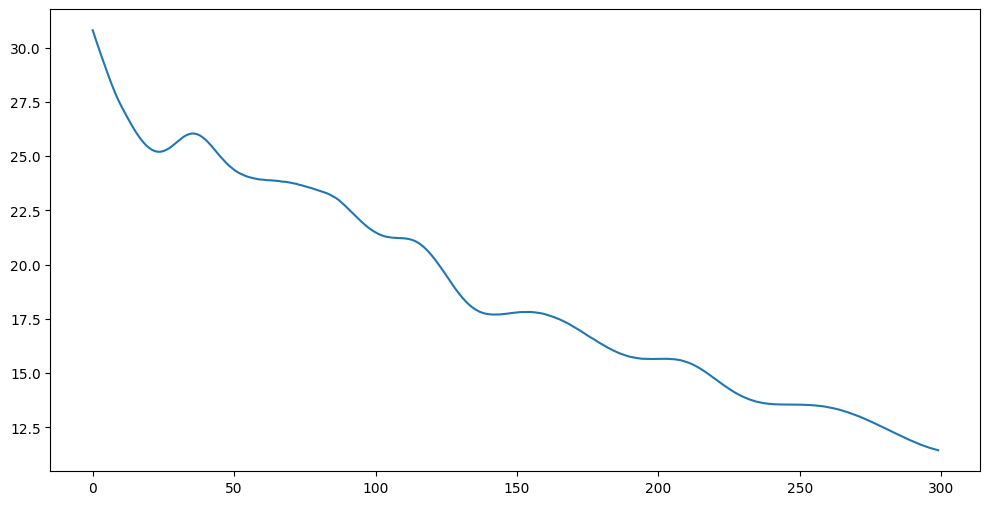

In [67]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [68]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [69]:
# our existing time series window function
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [70]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [71]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([189, 3, 42]) train_y: torch.Size([189, 1]) train_y_gan: torch.Size([189, 4, 1])
test_x: torch.Size([46, 3, 42]) test_y: torch.Size([46, 1]) test_y_gan: torch.Size([46, 4, 1])


In [72]:
# GRU + CNN
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [73]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(num_cols + 10).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 2.773190975189209 LossG:1.417050063610077
[2/165] LossD: 2.7726166248321533 LossG:1.4104374051094055
[3/165] LossD: 2.772292375564575 LossG:1.4044889211654663
[4/165] LossD: 2.77232825756073 LossG:1.399124264717102
[5/165] LossD: 2.7728540897369385 LossG:1.394426703453064
[6/165] LossD: 2.7733582258224487 LossG:1.3919099569320679
[7/165] LossD: 2.7727816104888916 LossG:1.3911386132240295
[8/165] LossD: 2.7724428176879883 LossG:1.3899400234222412
[9/165] LossD: 2.7724251747131348 LossG:1.3890522122383118
[10/165] LossD: 2.772454619407654 LossG:1.3880040645599365
[11/165] LossD: 2.772457242012024 LossG:1.3872509598731995
[12/165] LossD: 2.772413969039917 LossG:1.3868237137794495
[13/165] LossD: 2.772359251976013 LossG:1.3865752220153809
[14/165] LossD: 2.772332549095154 LossG:1.38646000623703
[15/165] LossD: 2.7723631858825684 LossG:1.3865249752998352
[16/165] LossD: 2.772379755973816 LossG:1.3867303133010864
[17/165] LossD: 2.7723875045776367 LossG:1.3867437839508057
[18/

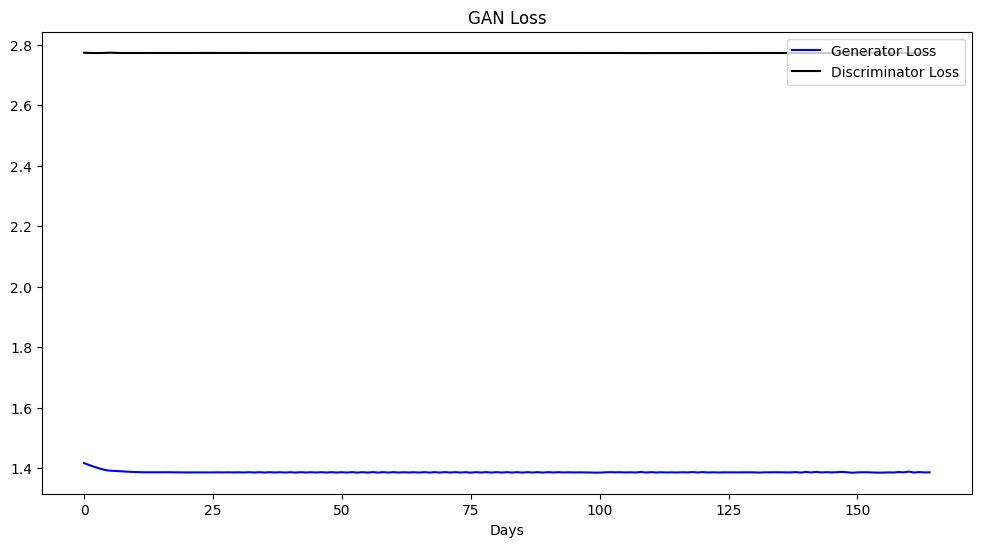

In [74]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [75]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.014997432460086158


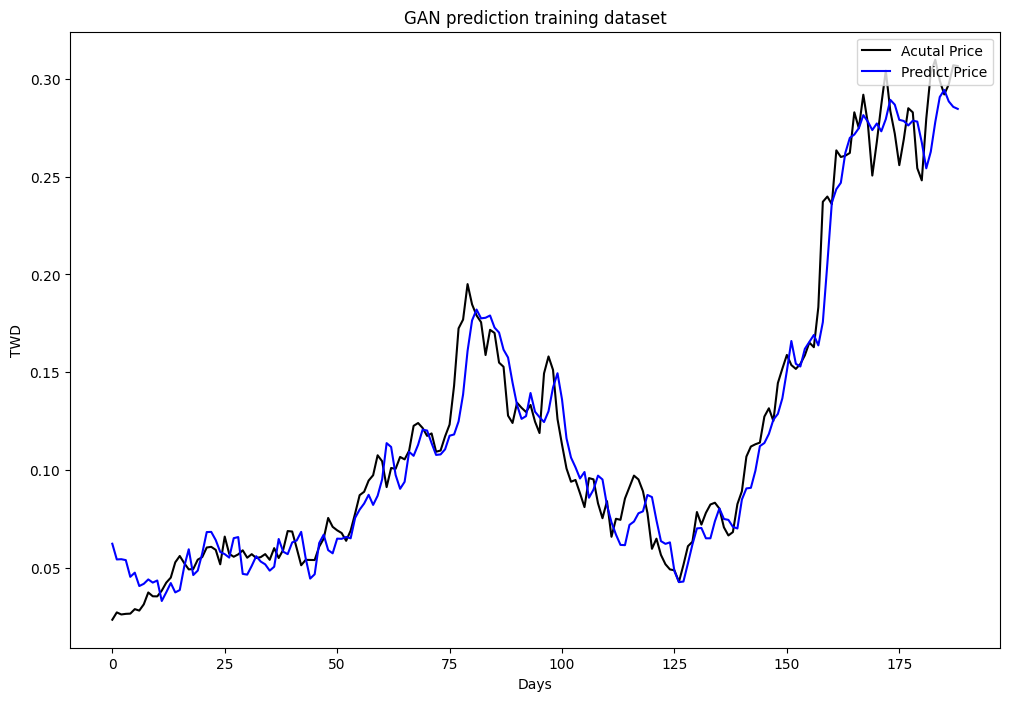

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.22849406936084815


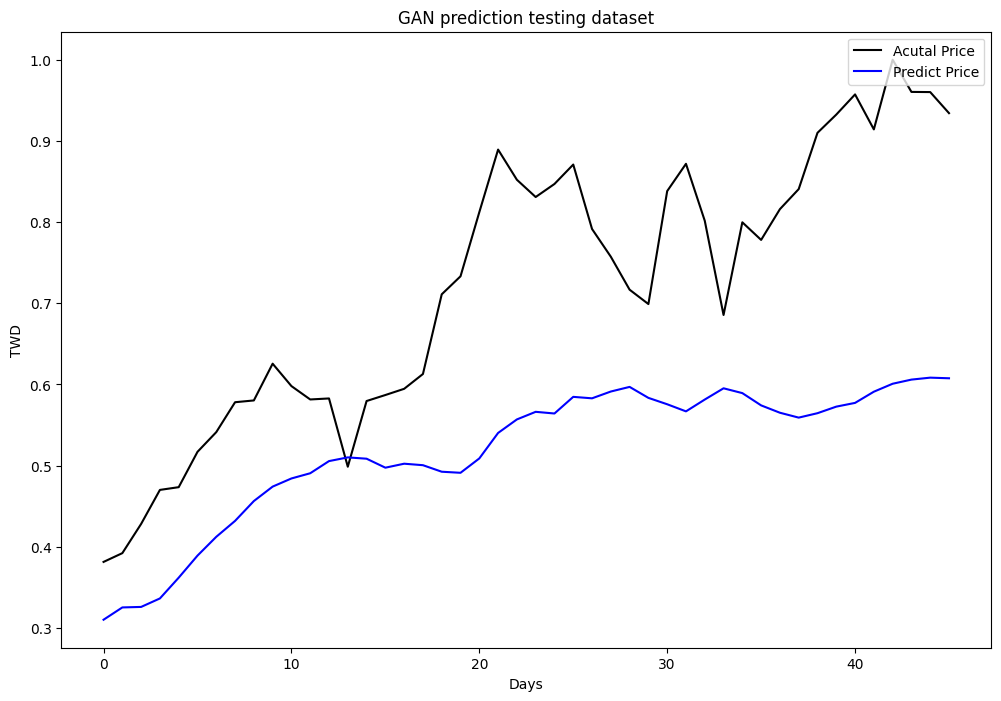

In [77]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')